In [1]:
import os

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image

In [2]:
%matplotlib inline

In [3]:
REPO_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
TASK_PATH = os.path.join(REPO_PATH, "tasks", "11-nn.md")
DATA_PATH = '/home/dima/Projects/UD_Ukrainian-IU'

In [4]:
def show_markdown(path):
    with open(path, 'r') as fh:
        content = fh.read()
    display(Markdown(content))

In [5]:
show_markdown(TASK_PATH)

# I. Нейромережі

У цьому завданні вам треба спробувати покращити з використанням нейромереж одну з двох ваших попередніх робіт:

1. Доробити парсер залежностей
2. Доробити класифікатор звернень до служби 1551

## Парсер залежностей

На основі FNN створіть класифікатор типу залежності. Для цього використайте:
- [UD-корпус для української мови](https://github.com/UniversalDependencies/UD_Ukrainian-IU/)
- парсер, який ви розробили в завданні 8 (або, якщо вам не вдалося реалізувати свій парсер, то можна взяти за основу [код із практичного заняття](../lectures/08-dep-parser-uk.ipynb))
- [векторні представлення слів для української мови](http://lang.org.ua/en/models/#anchor4)

Також переробіть свій парсер так, щоб замість використання ознак, визначених вручну, він покладався для вибору наступного переходу на передбачення LSTM-нейромережі, яка на вхід отримує поточні слова з тегами зі стеку та буферу (по 3 слова). Опис подібної мережі можна побачити у [цій статті](https://arxiv.org/pdf/1708.08959.pdf).

Обрахуйте якість класифікації та LAS для вашого парсера.

## Класифікатор звернень до служби 1551

Переробіть класифікатор звернень, який ви розробляли у завданні 10, так, щоб він використовував FNN на векторі документу та LSTM на векторах окремих слів. Порівняйте результати.

# II. Курсовий проєкт

Для свого курсового проєкту побудуйте рішення (чи кілька рішень), що перевершують по якості ваше базове рішення. Якість міряйте розробленими раніше метриками.
Код для курсового проєкту повинен бути у вашому репозиторії. У директорії `students/` в теці з вашим іменем збережіть файл з посиланням на код вашого рішення. Опишіть ваші результати.

# Оцінювання

I. За виконання одного з завдань ви можете отримати 80 балів. Якщо бажаєте, то можете виконати обидва і отримати 120 балів :)

II. За покращене рішення з курсового проєкту ви можете отримати 20 балів.

Крайній термін: 23.05.2020


## Dependancy parser

In [6]:
from collections import OrderedDict
from conllu import parse
from enum import Enum

In [7]:
%%time

with open(os.path.join(DATA_PATH, "uk_iu-ud-train.conllu"), "r") as f:
    train_trees = parse(f.read())

with open(os.path.join(DATA_PATH, "uk_iu-ud-dev.conllu"), "r") as f:
    test_trees = parse(f.read())

CPU times: user 3.22 s, sys: 132 ms, total: 3.35 s
Wall time: 3.35 s


In [8]:
print(len(train_trees), len(test_trees))

5496 672


In [9]:
def print_tree(tree):
    for node in tree:
        head = node["head"]
        print("{} <-- {}".format(node["form"],
                             tree[head - 1]["form"]
                             if head > 0 else "root"))

def check_tree(tree):
    for n in tree:
        if not isinstance(n["id"], int):
            return True
    return False

In [10]:
tree = train_trees[0]
print_tree(tree)

У <-- домі
домі <-- була
римського <-- патриція
патриція <-- домі
Руфіна <-- патриція
була <-- root
прегарна <-- фреска
фреска <-- була
, <-- зображення
зображення <-- фреска
Венери <-- зображення
та <-- Адоніса
Адоніса <-- Венери
. <-- була


In [11]:
print("Bad trees: " )
print("Train:", len(list(filter(check_tree, train_trees))))
print("Test:", len(list(filter(check_tree, test_trees))))

Bad trees: 
Train: 197
Test: 16


In [12]:
clean_train_trees = list(filter(lambda t: not check_tree(t), train_trees))
clean_test_trees = list(filter(lambda t: not check_tree(t), test_trees))

print(len(clean_train_trees), len(clean_test_trees))

5299 656


In [13]:
def intersects(n1, n2):
    s1 = n1['id'] if n1['head'] > n1['id'] else n1['head']
    e1 = n1['head'] if n1['head'] > n1['id'] else n1['id']
    s2 = n2['id'] if n2['head'] > n2['id'] else n2['head']
    e2 = n2['head'] if n2['head'] > n2['id'] else n2['id']
    
    return (s1 < s2 and e1 > s2 and e2 > e1) or (s2 < s1 and e2 > s1 and e1 > e2)

def non_projective(tree):
    for n1 in tree:
        for n2 in tree:
            if n1['id'] < n2['id'] and intersects(n1, n2):
                return True
            
    return False

In [14]:
non_projective_train_trees = list(filter(non_projective, clean_train_trees))
non_projective_test_trees = list(filter(non_projective, clean_test_trees))

print(len(non_projective_train_trees), len(non_projective_test_trees))

414 57


In [15]:
np_tree = non_projective_train_trees[21]
print_tree(np_tree)

Звісно <-- було
не <-- було
було <-- root
жодного <-- способу
способу <-- було
дізнатись <-- способу
чи <-- спостерігають
спостерігають <-- дізнатись
за <-- вами
вами <-- спостерігають
саме <-- цей
у <-- проміжок
цей <-- проміжок
проміжок <-- спостерігають
часу <-- проміжок
. <-- було


In [16]:
projective_train_trees = list(filter(lambda t: not non_projective(t), clean_train_trees))
projective_test_trees = list(filter(lambda t: not non_projective(t), clean_test_trees))

print(len(projective_train_trees), len(projective_test_trees))

4885 599


### Design actions and the oracle

In [17]:
class Actions(str, Enum):
    SHIFT = "shift"
    REDUCE = "reduce"
    RIGHT = "right"
    LEFT = "left"

In [18]:
def oracle(stack, top_queue, relations):
    """
    Make a decision on the right action to do.
    """
    top_stack = stack[-1]
    # check if both stack and queue are non-empty
    if top_stack and not top_queue:
        return Actions.REDUCE
    # check if there are any clear dependencies
    elif top_queue["head"] == top_stack["id"]:
        return Actions.RIGHT
    elif top_stack["head"] == top_queue["id"]:
        return Actions.LEFT
    # check if we can reduce the top of the stack
    elif top_stack["id"] in [i[0] for i in relations] and \
         (top_queue["head"] < top_stack["id"] or \
          [s for s in stack if s["head"] == top_queue["id"]]):
        return Actions.REDUCE
    # default option
    else:
        return Actions.SHIFT

In [19]:
ROOT = OrderedDict([('id', 0), ('form', 'ROOT'), ('lemma', 'ROOT'), ('upostag', 'ROOT'),
                    ('xpostag', None), ('feats', None), ('head', None), ('deprel', None),
                    ('deps', None), ('misc', None)])

def trace_actions(tree, log=True):
    """
    Try out the oracle to verify it's returning the right actions.
    """
    stack, queue, relations = [ROOT], tree[:], []
    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        if log:
            print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
            print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
            print("Relations:", relations)
            print(action)
            print("========================")
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()           
        else:
            print("Unknown action.")
    if log:
        print("Gold relations:")
        print([(node["id"], node["head"]) for node in tree])
        print("Retrieved relations:")
        print(sorted(relations))

### Feature extraction

In [20]:
import pandas as pd

In [21]:
def extract_features(stack, queue, relations=None):
    
    features = dict()
    
    if len(stack) > 1:        
        features["s0-word"] = stack[-2]["form"]
        features["s0-lemma"] = stack[-2]["lemma"]
        features["s0-tag"] = stack[-2]["upostag"]
#         features["s0-rchildren-num"] = len([r for r in relations if r[1] == stack[-2]['id']])
#         features["s0-lchildren-num"] = len([r for r in relations if r[0] == stack[-2]['id']])
        if stack[-2]["feats"]:
            for k, v in stack[-2]["feats"].items():
                features["s0-" + k] = v
    
    if len(stack) > 2:
        features["s1-word"] = stack[-3]["form"]
        features["s1-tag"] = stack[-3]["upostag"]
    
    if len(stack) > 3:
        features["s2-tag"] = stack[-4]["upostag"]
        
    if len(stack) > 4:
        features["s3-tag"] = stack[-5]["upostag"]
    
    if len(stack) > 1:
        queue_top = stack[-1]
        features["q0-word"] = stack[-1]["form"]
        features["q0-lemma"] = stack[-1]["lemma"]
        features["q0-tag"] = stack[-1]["upostag"]
#         features["q0-rchildren-num"] = len([r for r in relations if r[1] == stack[-1]['id']])
#         features["q0-lchildren-num"] = len([r for r in relations if r[0] == stack[-1]['id']])
        if stack[-1]["feats"]:
            for k, v in stack[-1]["feats"].items():
                features["q0-" + k] = v
    
    if len(queue) > 0:        
        features["q1-word"] = queue[0]["form"]
        features["q1-tag"] = queue[0]["upostag"]
    
    if len(queue) > 1:
        features["q2-tag"] = queue[1]["upostag"]
    
    if len(queue) > 2:
        features["q3-tag"] = queue[2]["upostag"]
       
    if len(stack) > 1:
        features["distance"] = stack[-1]["id"] - stack[-2]["id"]
    
    features['q-empty'] = not bool(queue)    
    
    return features


def extract_features_v2(stack, queue):
    features = dict()
    if len(stack) > 0:
        features["s0-word"] = stack[-1]["form"]
        features["s0-lemma"] = stack[-1]["lemma"]
        features["s0-tag"] = stack[-1]["upostag"]
    if len(stack) > 1:
        features["s1-tag"] = stack[-2]["upostag"]
    if queue:
        queue_top = queue[0]
        features["q0-word"] = queue[0]["form"]
        features["q0-lemma"] = queue[0]["lemma"]
        features["q0-tag"] = queue[0]["upostag"]
    if len(queue) > 1:
        queue_next = queue[1]
        features["q1-word"] = queue[1]["form"]
        features["q1-tag"] = queue[1]["upostag"]
    if len(queue) > 2:
        features["q2-tag"] = queue[2]["upostag"]
    if len(queue) > 3:
        features["q3-tag"] = queue[3]["upostag"]
    return features

In [22]:
def extract_data(tree):
    features, labels = [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        features.append(extract_features(stack, queue))
        labels.append(action.value)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels

#### train data

In [23]:
train_features, train_labels = [], []
for tree in train_trees:
    tree_features, tree_labels = extract_data([t for t in tree if type(t["id"])==int])
    train_features += tree_features
    train_labels += tree_labels

In [24]:
train_df = pd.DataFrame(train_features)
train_df['target'] = train_labels

In [25]:
print(train_df.shape)

(190298, 69)


#### test data

In [26]:
test_features, test_labels = [], []
for tree in test_trees:
    tree_features, tree_labels = extract_data([t for t in tree if type(t["id"])==int])
    test_features += tree_features
    test_labels += tree_labels

In [27]:
test_df = pd.DataFrame(test_features)
test_df['target'] = test_labels

In [28]:
print(test_df.shape)

(25820, 68)


### Train clasifier

In [29]:
RANDOM_STATE = 0
N_COMP = 500

In [30]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *

#### Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
vectorizer = DictVectorizer()
vec = vectorizer.fit(train_features)

print("\nTotal number of features: ", len(vec.get_feature_names()))


Total number of features:  115611


In [33]:
train_features_vectorized = vec.transform(train_features)
test_features_vectorized = vec.transform(test_features)

In [34]:
lr_clf = LogisticRegression(C=2, solver="sag", multi_class="multinomial", max_iter=1000, 
                            verbose=1, random_state=RANDOM_STATE)

In [35]:
lr_pipe = Pipeline([('vec', vec), ('lr_clf', lr_clf)])

In [36]:
# lr_clf.fit(train_features_vectorized, train_labels)
lr_pipe.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 165 seconds


/home/dima/anaconda3/envs/p36tf20/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


Pipeline(memory=None,
         steps=[('vec',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('lr_clf',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=0, solver='sag',
                                    tol=0.0001, verbose=1, warm_start=False))],
         verbose=False)

In [37]:
# predicted = lr_clf.predict(test_features_vectorized)
predicted = lr_pipe.predict(test_features)
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

        left       0.88      0.90      0.89      6371
      reduce       0.86      0.81      0.83      6875
       right       0.77      0.80      0.79      5996
       shift       0.85      0.87      0.86      6578

    accuracy                           0.84     25820
   macro avg       0.84      0.84      0.84     25820
weighted avg       0.84      0.84      0.84     25820



### Neural networks

In [38]:
import tensorflow as tf
from gensim.models.keyedvectors import KeyedVectors

In [39]:
def extract_features_nn(stack, queue):
    
    features = {
        "s0-form": None,
        "s0-tag": None,
        "s1-form": None,
        "s1-tag": None,
        "s2-form": None,
        "s2-tag": None,
        "q0-form": None,
        "q0-tag": None,
        "q1-form": None,
        "q1-tag": None,
        "q2-form": None,
        "q2-tag": None
    }
    
    if len(stack) > 1:        
        features["s0-form"] = stack[-2]["form"]
        features["s0-tag"] = stack[-2]["upostag"]
    
    if len(stack) > 2:
        features["s1-form"] = stack[-3]["form"]
        features["s1-tag"] = stack[-3]["upostag"]
    
    if len(stack) > 3:
        features["s2-form"] = stack[-4]["form"]
        features["s2-tag"] = stack[-4]["upostag"]
    
    if len(stack) > 1:
        queue_top = stack[-1]
        features["q0-form"] = stack[-1]["form"]
        features["q0-tag"] = stack[-1]["upostag"]
    
    if len(queue) > 0:        
        features["q1-form"] = queue[0]["form"]
        features["q1-tag"] = queue[0]["upostag"]
    
    if len(queue) > 1:
        features["q2-form"] = queue[1]["form"]
        features["q2-tag"] = queue[1]["upostag"]
    
    return features

In [40]:
no_action_label = 'N/A'

def extract_data_nn(tree):
    features, labels_dep, labels_act = [], [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        features.append(extract_features_nn(stack, queue))
        labels_act.append(action.value)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
            labels_dep.append(no_action_label)
        elif action == Actions.REDUCE:
            stack.pop()
            labels_dep.append(no_action_label)
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
#             features.append(extract_features_nn(stack, queue))
            labels_dep.append(stack[-1]["deprel"])
#             labels_act.append('left')
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
#             features.append(extract_features_nn(stack, queue))
            labels_dep.append(queue[0]["deprel"])
#             labels_act.append('right')
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels_dep, labels_act

In [41]:
w2v_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.word2vec.300d")

#### Generate features

In [42]:
train_features, train_labels_dep, train_labels_act = [], [], []
for tree in train_trees:
    tree_features, tree_labels_dep, tree_labels_act = extract_data_nn([t for t in tree if type(t["id"])==int])
    train_features += tree_features
    train_labels_dep += tree_labels_dep
    train_labels_act += tree_labels_act

In [43]:
test_features, test_labels_dep, test_labels_act = [], [], []
for tree in test_trees:
    tree_features, tree_labels_dep, tree_labels_act = extract_data_nn([t for t in tree if type(t["id"])==int])
    test_features += tree_features
    test_labels_dep += tree_labels_dep
    test_labels_act += tree_labels_act

In [44]:
def dict2df(feat_dict, labels_dep=None, labels_act=None):
    df = pd.DataFrame(feat_dict)
    df.columns = sorted(df.columns)
    if labels_dep:
        df['deprel'] = labels_dep
    if labels_act:
        df['action'] = labels_act
    return df

In [45]:
train_df = dict2df(train_features, train_labels_dep, train_labels_act)
test_df = dict2df(test_features, test_labels_dep, test_labels_act)

In [46]:
# train_df.head()
test_df.head()

,q0-form,q0-tag,q1-form,q1-tag,q2-form,q2-tag,s0-form,s0-tag,s1-form,s1-tag,s2-form,s2-tag,deprel,action
0,None,None,None,None,None,None,None,None,Дідусь,NOUN,",",PUNCT,N/A,shift
1,ROOT,ROOT,None,None,None,None,Дідусь,NOUN,",",PUNCT,той,DET,N/A,shift
2,Дідусь,NOUN,ROOT,ROOT,None,None,",",PUNCT,той,DET,що,SCONJ,punct,left
3,ROOT,ROOT,None,None,None,None,Дідусь,NOUN,той,DET,що,SCONJ,N/A,shift
4,Дідусь,NOUN,ROOT,ROOT,None,None,той,DET,що,SCONJ,атестував,VERB,N/A,shift


In [47]:
pos_columns = sorted([item for item in train_df.columns if item.endswith('tag')])
pos_columns

['q0-tag', 'q1-tag', 'q2-tag', 's0-tag', 's1-tag', 's2-tag']

In [48]:
form_columns = sorted([item for item in train_df.columns if item.endswith('form')])
form_columns

['q0-form', 'q1-form', 'q2-form', 's0-form', 's1-form', 's2-form']

In [49]:
pos_tags = list(sorted(filter(lambda x: isinstance(x, str), set(np.hstack(train_df[pos_columns].values)))))
pos_tags_mapping = dict(zip(pos_tags, range(1, len(pos_tags)+1)))
pos_tags_mapping

{'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'AUX': 4,
 'CCONJ': 5,
 'DET': 6,
 'INTJ': 7,
 'NOUN': 8,
 'NUM': 9,
 'PART': 10,
 'PRON': 11,
 'PROPN': 12,
 'PUNCT': 13,
 'ROOT': 14,
 'SCONJ': 15,
 'SYM': 16,
 'VERB': 17,
 'X': 18}

In [50]:
deprel = train_df['deprel'].unique()
deprel_mapping = dict(zip(deprel, range(len(deprel))))
inverse_deprel_mapping = {v:k for k, v in deprel_mapping.items()}
# deprel_mapping

In [51]:
action = train_df['action'].unique()
action_mapping = dict(zip(action, range(len(action))))
inverse_action_mapping = {v:k for k, v in action_mapping.items()}

In [52]:
def pos_ohe(x):
    res = np.zeros((1, len(pos_tags_mapping)))
    pos_idx = pos_tags_mapping.get(x)
    if pos_idx:
        res[:,pos_idx-1] = 1
    return res
    
def word_embed(x):
    if x in w2v_model.vocab:
        return w2v_model.__getitem__([x])
    else:
        return np.zeros((1, 300))

In [53]:
def make_nn_features(feats, labels_dep=None, labels_act=None):
    df = dict2df(feats, labels_dep, labels_act)
    
    res = []
    for col in form_columns:
        res.append(np.vstack(df[col].fillna('').map(word_embed).values))
    X_form = np.stack(res, axis=1)
    
    res = []
    for col in pos_columns:
        res.append(np.vstack(df[col].fillna('').map(pos_ohe).values))
    X_pos = np.stack(res, axis=1)
    
    res = []
    for col in pos_columns:
        res.append(np.hstack(df[col].fillna('').map(
            lambda x: pos_tags_mapping.get(x, len(pos_tags_mapping)+1)).values)#.reshape(-1, 1)
                  )
    X_pos_token = np.stack(res, axis=1)
    
    if labels_dep and labels_act:
        y_dep = df['deprel'].map(deprel_mapping)
        y_dep = tf.keras.utils.to_categorical(y_dep)
        y_act = df['action'].map(action_mapping)
        y_act = tf.keras.utils.to_categorical(y_act)
        return X_form, X_pos, X_pos_token, y_dep, y_act
    else:
        return X_form, X_pos, X_pos_token

In [54]:
X_form_train, X_pos_ohe_train, X_pos_token_train, y_dep_train, y_act_train = make_nn_features(train_features, train_labels_dep, train_labels_act)
X_form_test, X_pos_ohe_test, X_pos_token_test, y_dep_test, y_act_test = make_nn_features(test_features, test_labels_dep, test_labels_act)

print(X_form_train.shape, X_pos_ohe_train.shape, X_pos_token_train.shape, y_dep_train.shape, y_act_train.shape)

(190298, 6, 300) (190298, 6, 18) (190298, 6) (190298, 57) (190298, 4)


### separated embeddings for lstm

In [55]:
word_emb_input = tf.keras.layers.Input(shape=X_form_train.shape[1:])
pos_ohe_emb_input = tf.keras.layers.Input(shape=X_pos_ohe_train.shape[1:])
pos_token_emb_input = tf.keras.layers.Input(shape=X_pos_token_train.shape[1:])

pos_emb_layer = tf.keras.layers.Embedding(input_dim=len(pos_tags_mapping)+2, output_dim=32)(pos_token_emb_input)

lstm_word = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(word_emb_input)
lstm_pos_ohe = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(pos_ohe_emb_input)
lstm_pos_emb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(pos_emb_layer)

flat_word = tf.keras.layers.Flatten()(lstm_word)
flat_pos_ohe = tf.keras.layers.Flatten()(lstm_pos_ohe)
flat_pos_emb = tf.keras.layers.Flatten()(lstm_pos_emb)

flat_concat = tf.keras.layers.concatenate([flat_word, flat_pos_ohe, flat_pos_emb], axis=-1)
flat_concat = tf.keras.layers.Dropout(0.5)(flat_concat)

dense_layer1 = tf.keras.layers.Dense(128, activation='relu')(flat_concat)
dense_output_act = tf.keras.layers.Dense(len(action_mapping), activation='softmax', name='action')(dense_layer1)


dense_layer2 = tf.keras.layers.Dense(64, activation='relu')(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.3)(dense_layer2)

act_dense_concat = tf.keras.layers.concatenate([dense_output_act, dense_layer2], axis=-1)

dense_output_dep = tf.keras.layers.Dense(len(deprel_mapping), activation='softmax', name='deprel')(dense_layer2)



model = tf.keras.models.Model(inputs=[word_emb_input, pos_ohe_emb_input, pos_token_emb_input], 
                              outputs=[dense_output_dep, dense_output_act], 
                              name='lstm_separated_emb')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [56]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_deprel_categorical_accuracy', patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='lstm_separated_emb.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "lstm_separated_emb"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 6, 300)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 18)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6, 32)        640         input_3[0][0]                    
_________________________________________________________________________________

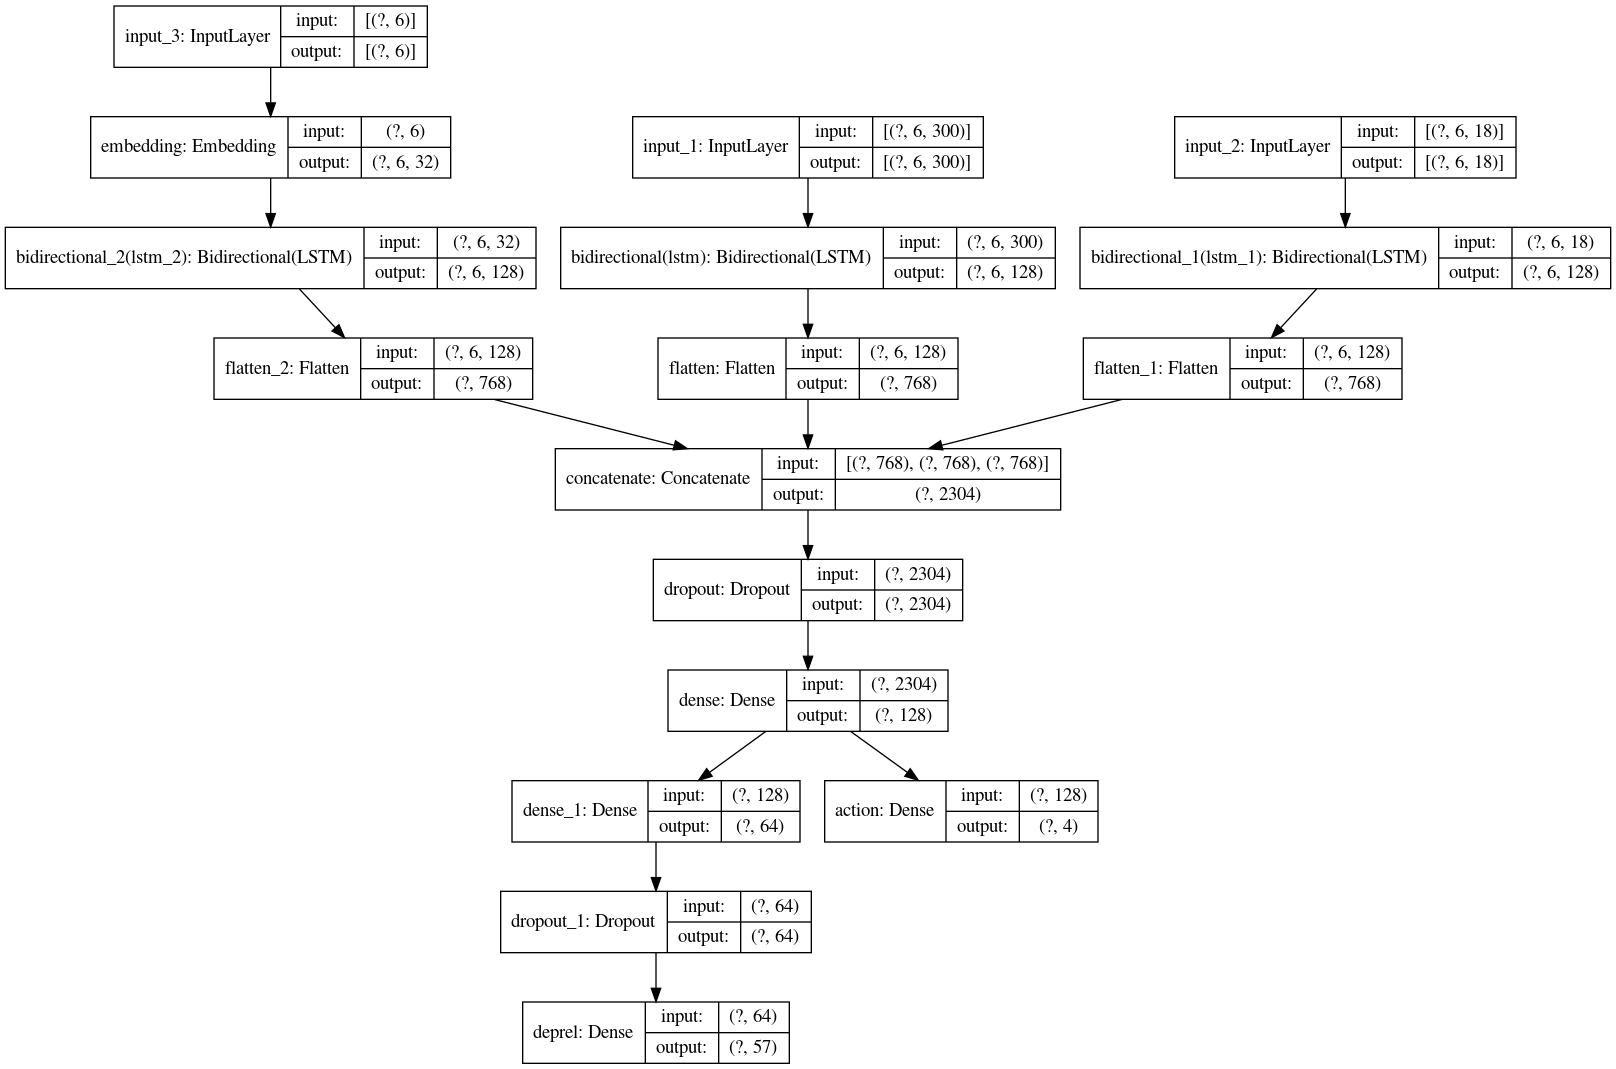

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [58]:
history = model.fit(x=[X_form_train, X_pos_ohe_train, X_pos_token_train], y=[y_dep_train, y_act_train],
#                     class_weight='balanced',
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=([X_form_test, X_pos_ohe_test, X_pos_token_test], [y_dep_test, y_act_test]),
                    verbose=1)

Train on 190298 samples, validate on 25820 samples
Epoch 1/100
190112/190298 [============================>.] - ETA: 0s - loss: 1.1632 - deprel_loss: 0.7391 - action_loss: 0.4241 - deprel_categorical_accuracy: 0.7712 - action_categorical_accuracy: 0.8350
Epoch 00001: val_loss improved from inf to 0.90328, saving model to lstm_separated_emb.h5
190298/190298 [==============================] - 57s 299us/sample - loss: 1.1629 - deprel_loss: 0.7389 - action_loss: 0.4240 - deprel_categorical_accuracy: 0.7712 - action_categorical_accuracy: 0.8350 - val_loss: 0.9033 - val_deprel_loss: 0.5293 - val_action_loss: 0.3739 - val_deprel_categorical_accuracy: 0.8201 - val_action_categorical_accuracy: 0.8541
Epoch 2/100
190144/190298 [============================>.] - ETA: 0s - loss: 0.8951 - deprel_loss: 0.5506 - action_loss: 0.3444 - deprel_categorical_accuracy: 0.8194 - action_categorical_accuracy: 0.8673
Epoch 00002: val_loss improved from 0.90328 to 0.85814, saving model to lstm_separated_emb.h5
1

Epoch 14/100
190240/190298 [============================>.] - ETA: 0s - loss: 0.4888 - deprel_loss: 0.3145 - action_loss: 0.1742 - deprel_categorical_accuracy: 0.8955 - action_categorical_accuracy: 0.9338
Epoch 00014: val_loss did not improve from 0.82055
190298/190298 [==============================] - 49s 257us/sample - loss: 0.4887 - deprel_loss: 0.3145 - action_loss: 0.1742 - deprel_categorical_accuracy: 0.8955 - action_categorical_accuracy: 0.9338 - val_loss: 0.9241 - val_deprel_loss: 0.5447 - val_action_loss: 0.3792 - val_deprel_categorical_accuracy: 0.8448 - val_action_categorical_accuracy: 0.8719
Epoch 15/100
190240/190298 [============================>.] - ETA: 0s - loss: 0.4837 - deprel_loss: 0.3120 - action_loss: 0.1717 - deprel_categorical_accuracy: 0.8959 - action_categorical_accuracy: 0.9347
Epoch 00015: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00015: val_loss did not improve from 0.82055
190298/190298 [==============================] - 49

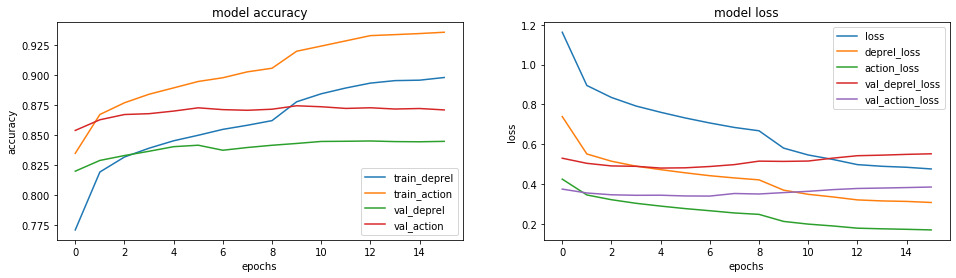

In [59]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['deprel_categorical_accuracy'])
plt.plot(history.history['action_categorical_accuracy'])
plt.plot(history.history['val_deprel_categorical_accuracy'])
plt.plot(history.history['val_action_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_deprel', 'train_action', 'val_deprel', 'val_action'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['deprel_loss'])
plt.plot(history.history['action_loss'])
plt.plot(history.history['val_deprel_loss'])
plt.plot(history.history['val_action_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'deprel_loss', 'action_loss', 'val_deprel_loss', 'val_action_loss'], loc='upper right')

plt.show()

In [60]:
lstm_separated = tf.keras.models.load_model('lstm_separated_emb.h5')

In [61]:
pred_dep, pred_act = lstm_separated.predict([X_form_test, X_pos_ohe_test, X_pos_token_test])

In [62]:
target_names = list(map(
    lambda x: inverse_deprel_mapping.get(x), 
    sorted(list(set((list(np.argmax(y_dep_test, axis=1)) + list(np.argmax(pred_dep, axis=1))))))
))

print(classification_report(
    np.argmax(pred_dep, axis=1),            
    np.argmax(y_dep_test, axis=1),
    target_names=target_names
))

                     precision    recall  f1-score   support

                N/A       0.91      0.89      0.90     13820
               case       0.99      0.99      0.99      1149
               amod       0.94      0.92      0.93      1034
               nmod       0.80      0.67      0.73      1435
         flat:title       0.57      0.50      0.53       206
                obl       0.76      0.62      0.68      1013
               root       0.86      0.91      0.89       610
              nsubj       0.79      0.73      0.76       852
              punct       0.81      0.85      0.83      2249
              appos       0.00      0.00      0.00         0
                 cc       0.92      0.92      0.92       439
               conj       0.27      0.44      0.33       335
             advmod       0.91      0.80      0.85       696
              advcl       0.09      0.41      0.15        27
          discourse       0.64      0.75      0.69       154
              xcomp    

/home/dima/anaconda3/envs/p36tf20/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(classification_report(
    np.argmax(pred_act, axis=1),            
    np.argmax(y_act_test, axis=1),
    target_names=inverse_action_mapping.values()
))

              precision    recall  f1-score   support

       shift       0.90      0.89      0.90      6659
        left       0.93      0.89      0.91      6665
       right       0.83      0.83      0.83      6013
      reduce       0.83      0.88      0.85      6483

    accuracy                           0.87     25820
   macro avg       0.87      0.87      0.87     25820
weighted avg       0.87      0.87      0.87     25820



### concatenated embeddings for lstm

In [67]:
word_emb_input = tf.keras.layers.Input(shape=X_form_train.shape[1:])
pos_ohe_emb_input = tf.keras.layers.Input(shape=X_pos_ohe_train.shape[1:])
pos_token_emb_input = tf.keras.layers.Input(shape=X_pos_token_train.shape[1:])

pos_emb_layer = tf.keras.layers.Embedding(input_dim=len(pos_tags_mapping)+2, output_dim=32)(pos_token_emb_input)

emb_concat = tf.keras.layers.concatenate([word_emb_input, pos_ohe_emb_input, pos_emb_layer], axis=-1)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(emb_concat)
flat = tf.keras.layers.Flatten()(lstm)
flat_concat = tf.keras.layers.Dropout(0.5)(flat)

dense_layer1 = tf.keras.layers.Dense(128, activation='relu')(flat_concat)
dense_output_act = tf.keras.layers.Dense(len(action_mapping), activation='softmax', name='action')(dense_layer1)


dense_layer2 = tf.keras.layers.Dense(64, activation='relu')(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.3)(dense_layer2)

act_dense_concat = tf.keras.layers.concatenate([dense_output_act, dense_layer2], axis=-1)

dense_output_dep = tf.keras.layers.Dense(len(deprel_mapping), activation='softmax', name='deprel')(dense_layer2)



model = tf.keras.models.Model(inputs=[word_emb_input, pos_ohe_emb_input, pos_token_emb_input], 
                              outputs=[dense_output_dep, dense_output_act], 
                              name='lstm_concatenated_emb')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [68]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_deprel_categorical_accuracy', patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='lstm_concatenated_emb.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "lstm_concatenated_emb"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 6, 300)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6, 18)]      0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 6, 32)        640         input_9[0][0]                    
______________________________________________________________________________

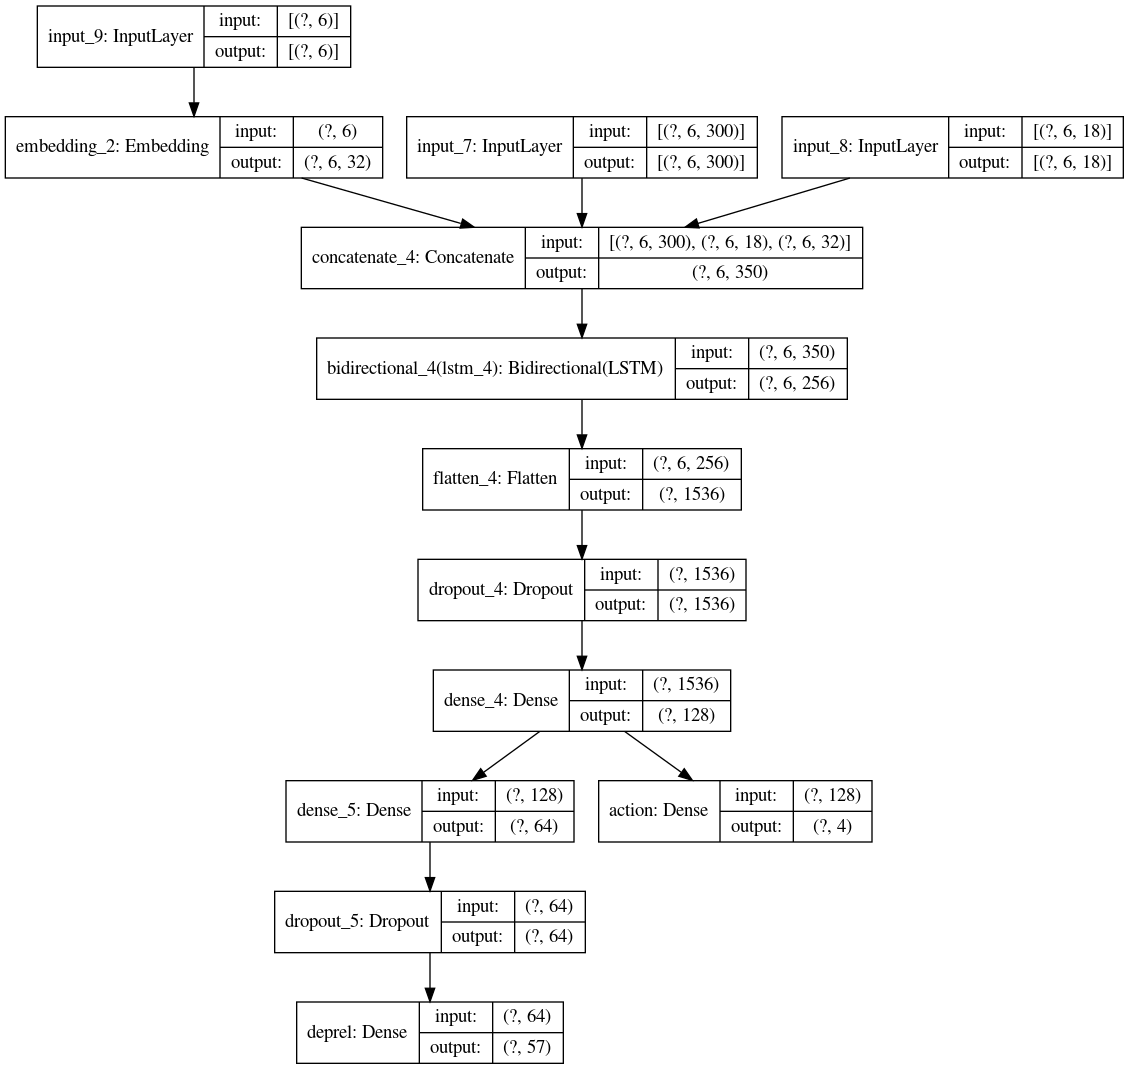

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [70]:
history = model.fit(x=[X_form_train, X_pos_ohe_train, X_pos_token_train], y=[y_dep_train, y_act_train],
#                     class_weight='balanced',
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=([X_form_test, X_pos_ohe_test, X_pos_token_test], [y_dep_test, y_act_test]),
                    verbose=1)

Train on 190298 samples, validate on 25820 samples
Epoch 1/100
190272/190298 [============================>.] - ETA: 0s - loss: 1.2216 - deprel_loss: 0.7929 - action_loss: 0.4287 - deprel_categorical_accuracy: 0.7615 - action_categorical_accuracy: 0.8335
Epoch 00001: val_loss improved from inf to 0.89995, saving model to lstm_concatenated_emb.h5
190298/190298 [==============================] - 33s 174us/sample - loss: 1.2215 - deprel_loss: 0.7928 - action_loss: 0.4287 - deprel_categorical_accuracy: 0.7615 - action_categorical_accuracy: 0.8335 - val_loss: 0.8999 - val_deprel_loss: 0.5357 - val_action_loss: 0.3642 - val_deprel_categorical_accuracy: 0.8203 - val_action_categorical_accuracy: 0.8576
Epoch 2/100
190016/190298 [============================>.] - ETA: 0s - loss: 0.9058 - deprel_loss: 0.5676 - action_loss: 0.3383 - deprel_categorical_accuracy: 0.8170 - action_categorical_accuracy: 0.8701
Epoch 00002: val_loss improved from 0.89995 to 0.84560, saving model to lstm_concatenated_em

Epoch 14/100
190240/190298 [============================>.] - ETA: 0s - loss: 0.4450 - deprel_loss: 0.2932 - action_loss: 0.1518 - deprel_categorical_accuracy: 0.9035 - action_categorical_accuracy: 0.9420
Epoch 00014: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00014: val_loss did not improve from 0.82141
190298/190298 [==============================] - 29s 153us/sample - loss: 0.4450 - deprel_loss: 0.2932 - action_loss: 0.1518 - deprel_categorical_accuracy: 0.9035 - action_categorical_accuracy: 0.9420 - val_loss: 0.9884 - val_deprel_loss: 0.5825 - val_action_loss: 0.4058 - val_deprel_categorical_accuracy: 0.8466 - val_action_categorical_accuracy: 0.8758
Epoch 15/100
190080/190298 [============================>.] - ETA: 0s - loss: 0.4353 - deprel_loss: 0.2870 - action_loss: 0.1483 - deprel_categorical_accuracy: 0.9047 - action_categorical_accuracy: 0.9433
Epoch 00015: val_loss did not improve from 0.82141
190298/190298 [==============================] - 31

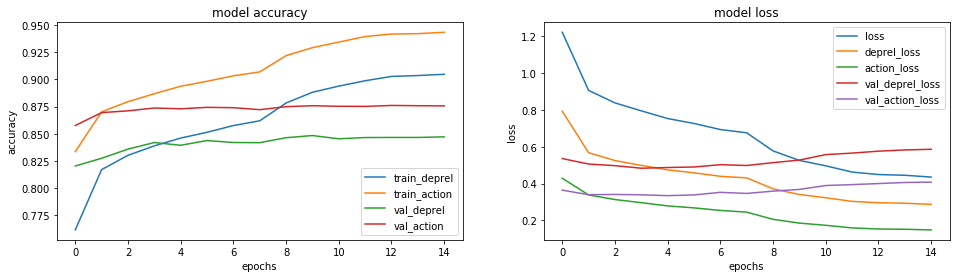

In [71]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['deprel_categorical_accuracy'])
plt.plot(history.history['action_categorical_accuracy'])
plt.plot(history.history['val_deprel_categorical_accuracy'])
plt.plot(history.history['val_action_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_deprel', 'train_action', 'val_deprel', 'val_action'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['deprel_loss'])
plt.plot(history.history['action_loss'])
plt.plot(history.history['val_deprel_loss'])
plt.plot(history.history['val_action_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'deprel_loss', 'action_loss', 'val_deprel_loss', 'val_action_loss'], loc='upper right')

plt.show()

In [72]:
lstm_concatenated = tf.keras.models.load_model('lstm_concatenated_emb.h5')

In [73]:
pred_dep, pred_act = lstm_concatenated.predict([X_form_test, X_pos_ohe_test, X_pos_token_test])

In [74]:
target_names = list(map(
    lambda x: inverse_deprel_mapping.get(x), 
    sorted(list(set((list(np.argmax(y_dep_test, axis=1)) + list(np.argmax(pred_dep, axis=1))))))
))

print(classification_report(
    np.argmax(pred_dep, axis=1),            
    np.argmax(y_dep_test, axis=1),
    target_names=target_names
))

                     precision    recall  f1-score   support

                N/A       0.92      0.87      0.89     14123
               case       0.99      0.98      0.99      1164
               amod       0.95      0.92      0.94      1055
               nmod       0.77      0.66      0.71      1404
         flat:title       0.13      0.69      0.22        35
                obl       0.69      0.73      0.71       785
               root       0.91      0.85      0.88       687
              nsubj       0.79      0.71      0.75       873
              punct       0.83      0.84      0.83      2322
              appos       0.00      0.00      0.00         0
                 cc       0.91      0.93      0.92       435
               conj       0.32      0.43      0.37       416
             advmod       0.84      0.84      0.84       611
              advcl       0.09      0.46      0.16        24
          discourse       0.66      0.72      0.69       163
              xcomp    

/home/dima/anaconda3/envs/p36tf20/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print(classification_report(
    np.argmax(pred_act, axis=1),            
    np.argmax(y_act_test, axis=1),
    target_names=inverse_action_mapping.values()
))

              precision    recall  f1-score   support

       shift       0.91      0.89      0.90      6727
        left       0.92      0.90      0.91      6550
       right       0.83      0.83      0.83      6016
      reduce       0.83      0.87      0.85      6527

    accuracy                           0.87     25820
   macro avg       0.87      0.87      0.87     25820
weighted avg       0.87      0.87      0.87     25820



### word emb + pos one-hot on 2 separated lstm

In [92]:
word_emb_input = tf.keras.layers.Input(shape=X_form_train.shape[1:])
pos_emb_input = tf.keras.layers.Input(shape=X_pos_ohe_train.shape[1:])

lstm_pos = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(pos_emb_input)
lstm_word = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(word_emb_input)
flat_pos = tf.keras.layers.Flatten()(lstm_pos)
flat_word = tf.keras.layers.Flatten()(lstm_word)
flat_concat = tf.keras.layers.concatenate([flat_pos, flat_word], axis=-1)
flat_concat = tf.keras.layers.Dropout(0.3)(flat_concat)

dense_layer1 = tf.keras.layers.Dense(128, activation='relu')(flat_concat)
dense_output_act = tf.keras.layers.Dense(len(action_mapping), activation='softmax', name='action')(dense_layer1)


dense_layer2 = tf.keras.layers.Dense(64, activation='relu')(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.3)(dense_layer2)

act_dense_concat = tf.keras.layers.concatenate([dense_output_act, dense_layer2], axis=-1)

dense_output_dep = tf.keras.layers.Dense(len(deprel_mapping), activation='softmax', name='deprel')(dense_layer2)



model = tf.keras.models.Model(inputs=[word_emb_input, pos_emb_input], 
                              outputs=[dense_output_dep, dense_output_act], 
                              name='form_pos_lstm')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [93]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_deprel_categorical_accuracy', patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='lstm_form_pos_ohe.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "form_pos_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 6, 18)]      0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 6, 300)]     0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 6, 128)       42496       input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 6, 128)       186880      input_15[0][0]                   
______________________________________________________________________________________

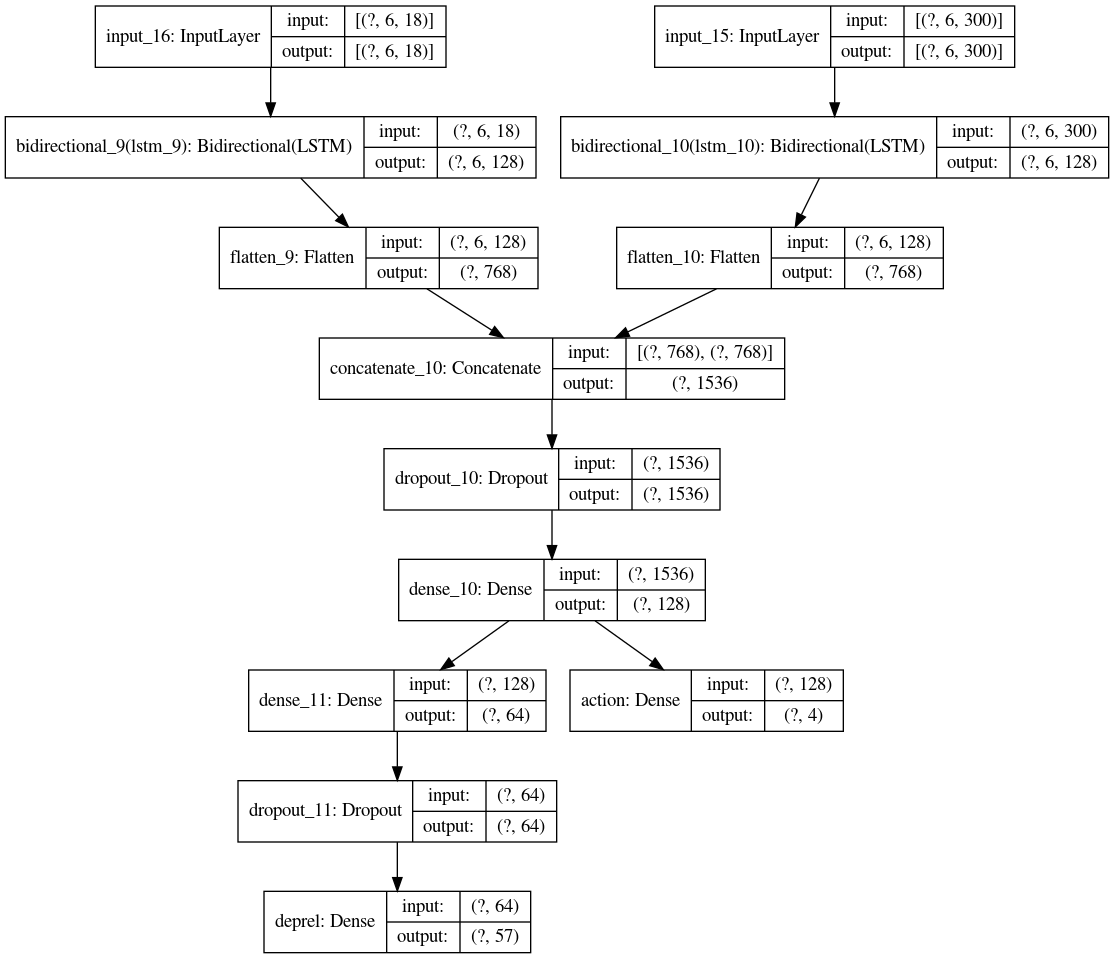

In [94]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [95]:
history = model.fit(x=[X_form_train, X_pos_ohe_train], y=[y_dep_train, y_act_train],
#                     class_weight='balanced',
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=([X_form_test, X_pos_ohe_test], [y_dep_test, y_act_test]),
                    verbose=1)

Train on 190298 samples, validate on 25820 samples
Epoch 1/100
190080/190298 [============================>.] - ETA: 0s - loss: 1.1549 - deprel_loss: 0.7342 - action_loss: 0.4206 - deprel_categorical_accuracy: 0.7741 - action_categorical_accuracy: 0.8371
Epoch 00001: val_loss improved from inf to 0.89953, saving model to lstm_form_pos_ohe.h5
190298/190298 [==============================] - 46s 241us/sample - loss: 1.1546 - deprel_loss: 0.7340 - action_loss: 0.4206 - deprel_categorical_accuracy: 0.7741 - action_categorical_accuracy: 0.8371 - val_loss: 0.8995 - val_deprel_loss: 0.5271 - val_action_loss: 0.3723 - val_deprel_categorical_accuracy: 0.8192 - val_action_categorical_accuracy: 0.8567
Epoch 2/100
190144/190298 [============================>.] - ETA: 0s - loss: 0.8542 - deprel_loss: 0.5271 - action_loss: 0.3271 - deprel_categorical_accuracy: 0.8269 - action_categorical_accuracy: 0.8740
Epoch 00002: val_loss improved from 0.89953 to 0.84485, saving model to lstm_form_pos_ohe.h5
190

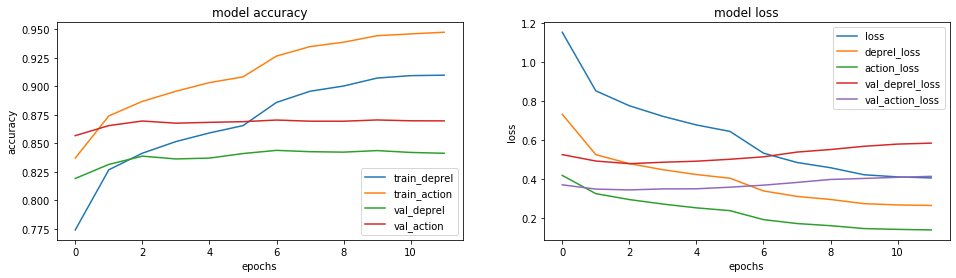

In [96]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['deprel_categorical_accuracy'])
plt.plot(history.history['action_categorical_accuracy'])
plt.plot(history.history['val_deprel_categorical_accuracy'])
plt.plot(history.history['val_action_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_deprel', 'train_action', 'val_deprel', 'val_action'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['deprel_loss'])
plt.plot(history.history['action_loss'])
plt.plot(history.history['val_deprel_loss'])
plt.plot(history.history['val_action_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'deprel_loss', 'action_loss', 'val_deprel_loss', 'val_action_loss'], loc='upper right')

plt.show()

In [97]:
lstm_form_pos_ohe = tf.keras.models.load_model('lstm_form_pos_ohe.h5')

In [98]:
pred_dep, pred_act = lstm_form_pos_ohe.predict([X_form_test, X_pos_ohe_test])

In [99]:
target_names = list(map(
    lambda x: inverse_deprel_mapping.get(x), 
    sorted(list(set((list(np.argmax(y_dep_test, axis=1)) + list(np.argmax(pred_dep, axis=1))))))
))

print(classification_report(
    np.argmax(pred_dep, axis=1),            
    np.argmax(y_dep_test, axis=1),
    target_names=target_names
))

                     precision    recall  f1-score   support

                N/A       0.91      0.88      0.90     13994
               case       1.00      0.97      0.98      1185
               amod       0.96      0.91      0.93      1074
               nmod       0.82      0.65      0.72      1535
         flat:title       0.24      0.52      0.33        85
                obl       0.65      0.72      0.68       749
               root       0.82      0.93      0.87       573
              nsubj       0.81      0.69      0.75       912
              punct       0.82      0.84      0.83      2307
              appos       0.00      0.00      0.00         0
                 cc       0.89      0.92      0.91       425
               conj       0.24      0.45      0.32       302
             advmod       0.92      0.76      0.83       729
              advcl       0.08      0.47      0.13        19
          discourse       0.62      0.78      0.69       143
              xcomp    

/home/dima/anaconda3/envs/p36tf20/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
print(classification_report(
    np.argmax(pred_act, axis=1),            
    np.argmax(y_act_test, axis=1),
    target_names=inverse_action_mapping.values()
))

              precision    recall  f1-score   support

       shift       0.90      0.88      0.89      6762
        left       0.92      0.89      0.90      6569
       right       0.82      0.84      0.83      5891
      reduce       0.83      0.87      0.85      6598

    accuracy                           0.87     25820
   macro avg       0.87      0.87      0.87     25820
weighted avg       0.87      0.87      0.87     25820



### Calculate the labeled attachment score

In [102]:
from tqdm import tqdm

In [105]:
def dep_parse(sentence, oracle=lstm_separated, log=False):
    stack, queue, relations, relations_with_dep = [ROOT], sentence[:], [], []
    while queue or stack:
        if stack and not queue:
            stack.pop()
        else:
            feat_form, feat_pos_ohe, feat_pos_token = make_nn_features([extract_features_nn(stack, queue)])
            
            deprel_pred, action_pred = oracle.predict([feat_form, feat_pos_ohe, feat_pos_token])
            deprel = inverse_deprel_mapping.get(np.argmax(deprel_pred))
            action = inverse_action_mapping.get(np.argmax(action_pred))

            if log:
                print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
                print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
                print("Relations:", relations)
                print(action)
                print("========================")
            # actual parsing
            if action == Actions.SHIFT:
                stack.append(queue.pop(0))
            elif action == Actions.REDUCE:
                stack.pop()
            elif action == Actions.LEFT:
                relations.append((stack[-1]["id"], queue[0]["id"]))
                relations_with_dep.append((stack[-1]["id"], queue[0]["id"], deprel))
                stack.pop()
            elif action == Actions.RIGHT:
                relations.append((queue[0]["id"], stack[-1]["id"]))
                relations_with_dep.append((queue[0]["id"], stack[-1]["id"], deprel))
                stack.append(queue.pop(0))
            else:
                print("Unknown action.")
    return sorted(relations), sorted(relations_with_dep)

In [106]:
total, tp, tp_dep = 0, 0, 0
for tree in tqdm(test_trees):
    tree = [t for t in tree if type(t["id"])==int]
    golden = [(node["id"], node["head"]) for node in tree]
    golden_dep = [(node["id"], node["head"], node["deprel"]) for node in tree]
    predicted, predicted_with_dep = dep_parse(tree, lstm_separated)
    total += len(tree)
    tp += len(set(golden).intersection(set(predicted)))
    tp_dep += len(set(golden_dep).intersection(set(predicted_with_dep)))

print("Total:", total)
print("Correctly defined:", tp)
print("UAS:", round(tp/total, 2))
print("LAS:", round(tp_dep/total, 2))

100%|██████████| 672/672 [15:57<00:00,  1.43s/it]

Total: 12574
Correctly defined: 9649
UAS: 0.77
LAS: 0.67
